# Segment and Convert  biosignals, then compare cleaning methods for each modality
Segment : cut the different acquisitions recorded in the same file (multi-run recordings).

Convert : change the file type (from `.acq` to `.hdf5`).

Cleaning : preparing signals for processing and confounds for fmri.

#### Dependencies

In [30]:
import pandas as pd
import numpy as np
import os
import h5py

In [2]:
import neurokit2 as nk2
import neurokit as nk
import matplotlib.pyplot as plt
import seaborn as sns

In [269]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 6.0)  
plt.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


/home/francois.lespinasse/anaconda3/envs/biosigEnv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time', 'info', 'exp']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [270]:
sns.set_style('darkgrid')

In [272]:
plt.ion()

#### import some code

In [46]:
%run ./code/conversion/test/convert_seg2hdf.py

# Segmentation and Conversion
Make a list of files for a single subject and cut it



In [5]:
help(list_sub)

Help on function list_sub in module __main__:

list_sub(root=None, sub=None, ses=None, type='.acq', show=False)
    List a subject's files.
    
    Returns a dictionary entry for each session in a subject's directory
    Each entry is a list of files for a given subject/ses directory
    if ses is given, only one dictionary entry is returned
    
    Arguments
    ---------
    root : str path
        root directory of dataset, like "home/user/dataset"
    sub : str BIDS code
        subject number, like "sub-01"
    ses : str BIDS code
        session name or number, like "ses-001"
    type : str
        what file are we looking for. Default is biosignals from biopac
    show : bool
        Defaults to False. Else, prints dictionary output
    Returns
    -------
    ses_list :
        list of sessions in the subject's folder
    files_list :
        list of files by their name
    
    Example :
    >>> ses_runs = list_sub(root = "/home/user/dataset", sub = "sub-01")



In [23]:
ls = list_sub('/data/neuromod/DATA/cneuromod/movie10/sourcedata/physio', sub='sub-01', show=True)

list of files for session ses-007 []
list of files for session ses-009 ['fast sampling rate data2019-05-10T10_22_08.acq', 'fast sampling rate data2019-05-10T11_26_17.acq']
list of files for session ses-003 ['sub-01_ses-wolfofwallstreet1.acq']
list of files for session ses-010 ['neuromod_video52019-05-29T15_39_51.acq']
list of files for session ses-004 ['sub-01_ses-wolfofwallstreet2-3a.acq']
list of files for session ses-006 ['sub-01_ses-wolfofwallstreet.acq', 'sub-01_ses-life1.acq']
list of files for session ses-012 ['neuromod_video52019-08-19T15_18_25.acq']
list of files for session ses-001 ['sub-01_ses-bournesup01.acq']
list of files for session ses-005 ['sub-01_ses-wolfofwallstreet2-3a.acq']
list of files for session ses-011 ['neuromod_video52019-07-03T10_57_27.acq']
list of files for session ses-002 ['sub-01_ses-bournesup02.acq']
list of files for session ses-008 ['fast sampling rate data2019-05-03T15_41_57.acq']


### homebrewed method

In [9]:
help(batch_parse)

Help on function batch_parse in module __main__:

batch_parse(root, subject, ses=None, save_path=None)
    Automated signal parsing for biopac recordings following BIDS format.
    
    Make sure the trigger channel is named "TTL" because it is hard-coded
    Parameters:
    ------------
    root : path
        main directory containing the biopac data (e.g. /home/user/dataset)
    subject : string
        name of path for a specific subject (e.g.'sub-03')
    ses : string
        name of acquisition session. Optional workflow for specific experiment
        default is None
    save_path: path
        root directory of



sub-03_ses-010_task_run01 in file  neuromod_video52019-06-04T14_32_53.acq 
in experiment: ses-010 is parsed. 
and saved at /home/francois.lespinasse/physiological-signals/tests/conversion/ | sampling rate is : 10000.0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub-03_ses-010_task_run02 in file  neuromod_video52019-06-04T14_32_53.acq 
in experiment: ses-010 is parsed. 
and saved at /home/francois.lespinasse/physiological-signals/tests/conversion/ | sampling rate is : 10000.0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub-03_ses-010_task_run03 in file  neuromod_video52019-06-04T14_32_53.acq 
in experiment: ses-010 is parsed. 
and saved at /home/francois.lespinasse/physiological-signals/tests/conversion/ | sampling rate is : 10000.0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sub-03_ses-010_task_run04 in file  neuromod_video52019-06-04T14_32_53.acq 
in experiment: ses-010 is parsed. 
and saved at /home/francois.lespinasse/physiological-signals/tests/conversion/ | sampling rate is : 10000.0 
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~

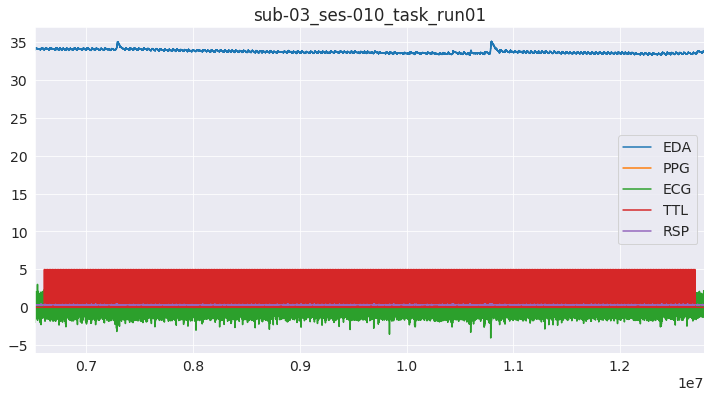

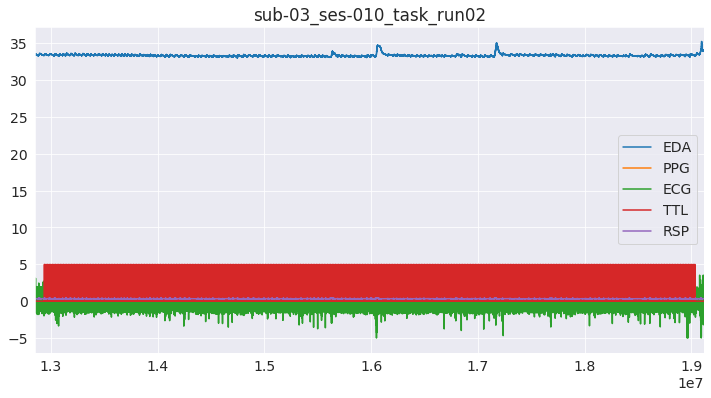

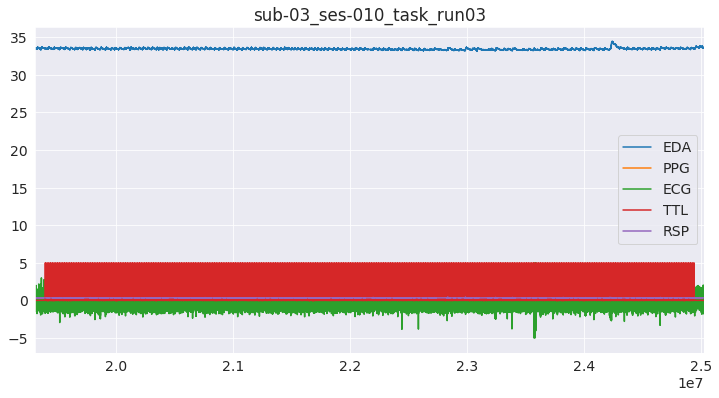

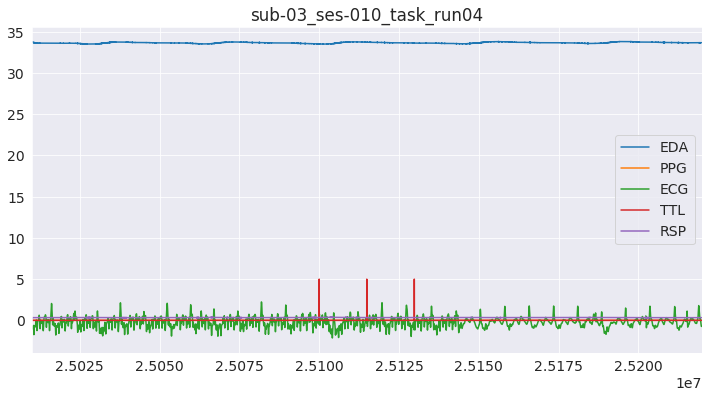

In [47]:
files = batch_parse("/data/neuromod/DATA/cneuromod/movie10/sourcedata/physio", subject='sub-03', ses='ses-010', save_path="/home/francois.lespinasse/physiological-signals/tests/conversion/")

### Plot are saved along with the files
let's look at a run

In [50]:
bio_df = pd.read_hdf('/home/francois.lespinasse/physiological-signals/tests/conversion/sub-03/ses-010/sub-03_ses-010_task_run03.h5', key='bio_df')

In [52]:
fs = pd.read_hdf('/home/francois.lespinasse/physiological-signals/tests/conversion/sub-03/ses-010/sub-03_ses-010_task_run03.h5', key='sampling_rate')

In [99]:
fs = int(fs)

column names are simpler and readable. They follow a convention... still to be made

In [51]:
bio_df.keys()

Index(['EDA', 'PPG', 'ECG', 'TTL', 'RSP'], dtype='object')

In [274]:
time = np.arange(len(bio_df))/fs

---------------------------
###

# PREPROCESSING

# EDA

Text(0, 0.5, 'µSiemens')

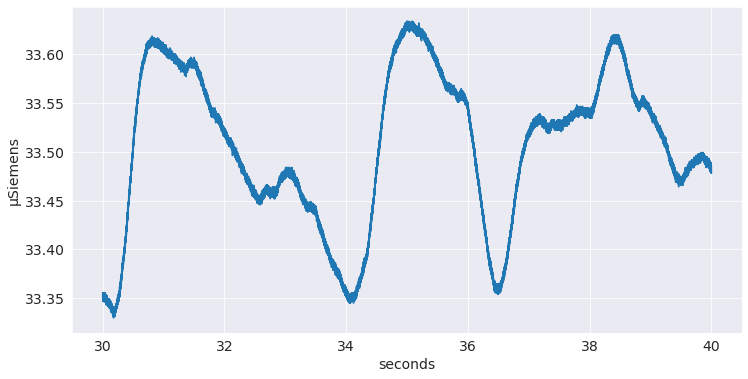

In [275]:
eda_raw = bio_df['EDA']
plt.plot(time[300000:400000], eda_raw[300000:400000])
plt.xlabel("seconds")
plt.ylabel("µSiemens")

## BioSPPy cleaning method specs
* Lowpass - 5Hz (normalized freq)

* Butterworth

* order 4

* smoothing convolution with boxzen kernel and window size of 0.75 * sampling_rate

In [276]:
eda_clean_biosppy = nk2.eda_clean(eda_raw, fs, method='biosppy')

Text(0, 0.5, 'µSiemens')

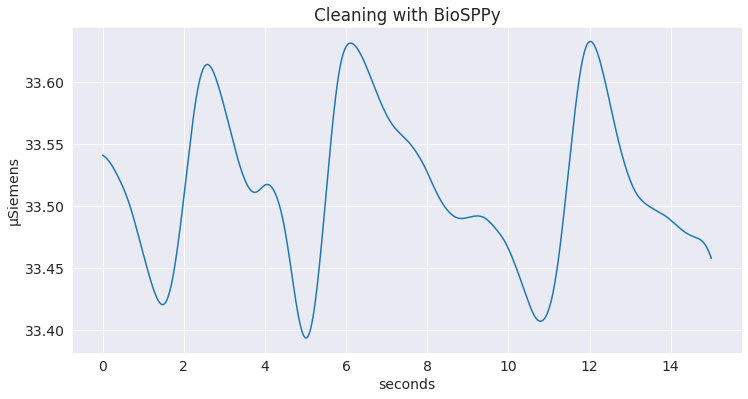

In [277]:
plt.plot(time[:150000], eda_clean_biosppy[:150000])
plt.title('Cleaning with BioSPPy')
plt.xlabel("seconds")
plt.ylabel("µSiemens")

## Neurokit EDA cleaning methods specs
* hightcut - 3Hz

* Butterworth

* order 4

* no convolution

In [278]:
eda_clean_nk = nk2.eda_clean(eda_raw, fs, method='neurokit')

Text(0, 0.5, 'µSiemens')

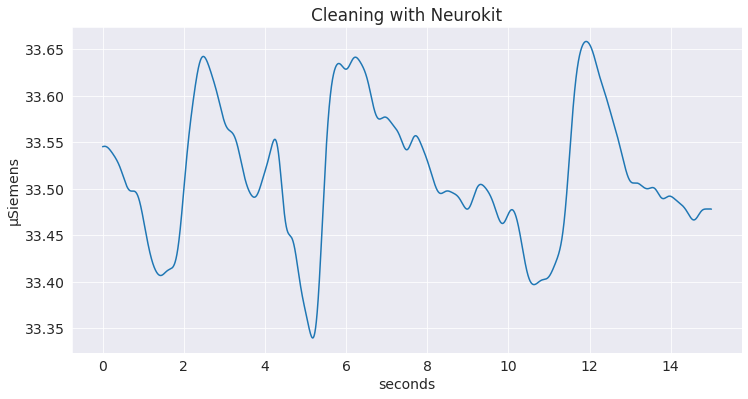

In [279]:
plt.plot(time[:150000], eda_clean_nk[:150000])
plt.title('Cleaning with Neurokit')
plt.xlabel("seconds")
plt.ylabel("µSiemens")

### Process with neurokit default pipeline

``clean - find_peaks - fix_peaks - compute measures of interest`` 

In [280]:
eda_proc, eda_info = nk2.eda_process(np.array(bio_df['EDA']), sampling_rate=fs)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

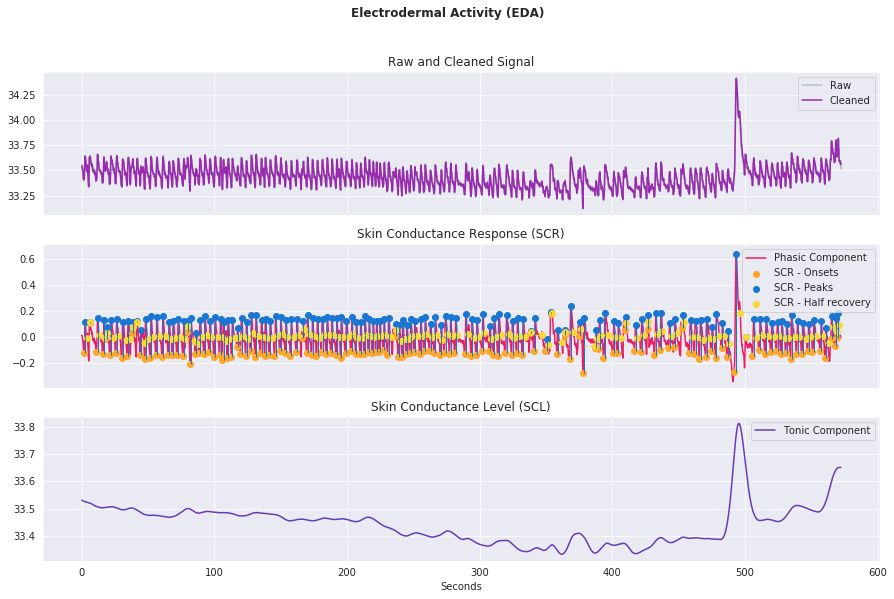

In [262]:
eda_fig = nk2.eda_plot(eda_proc, sampling_rate=fs)

In [16]:
eda_info.keys()

dict_keys(['SCR_Onsets', 'SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery', 'SCR_RecoveryTime'])

In [292]:
print('Skin conductance response happens on average, once every ',60/(len(eda_info['SCR_Peaks'])/10), 's')

Skin conductance response happens on average, once every  4.316546762589928 s


### Downsample
250 Hz

In [81]:
eda_down = nk2.signal_resample(eda_clean, sampling_rate=fs, desired_sampling_rate=250, method='interpolation')

Text(0, 0.5, 'µSiemens')

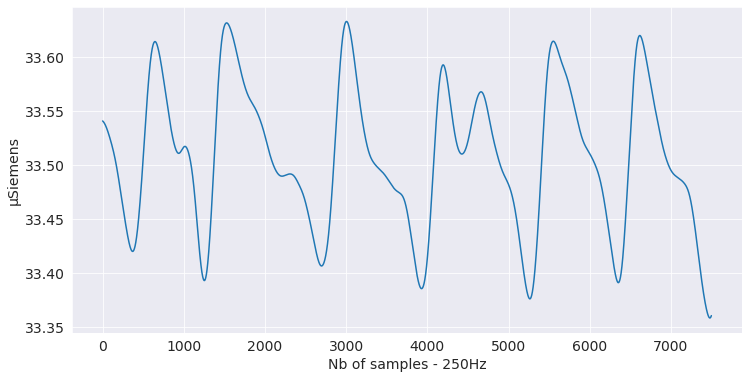

In [82]:
plt.plot(eda_down[:7500])
plt.xlabel("Nb of samples - 250Hz")
plt.ylabel("µSiemens")

# RSP

Text(0, 0.5, 'Volts')

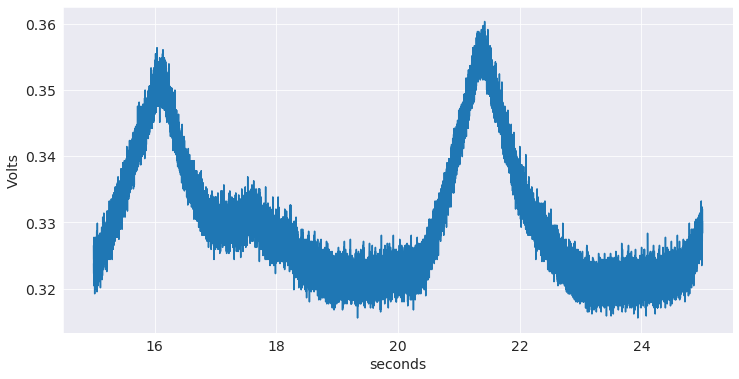

In [94]:
plt.plot(time[150000:250000], bio_df['RSP'][150000:250000])

plt.xlabel("seconds")
plt.ylabel("Volts")

## RSP clean - Khodadad2018
Remove baseline by applying a lowcut at .05Hz (preserves breathing rates higher than 3 breath per minute) and high frequency noise by applying a highcut at 3 Hz (preserves breathing rates slower than 180 breath per minute).

In [88]:
rsp_clean_kho = nk2.rsp_clean(bio_df['RSP'], sampling_rate=fs, method='khodadad2018')

Text(0, 0.5, 'Volts')

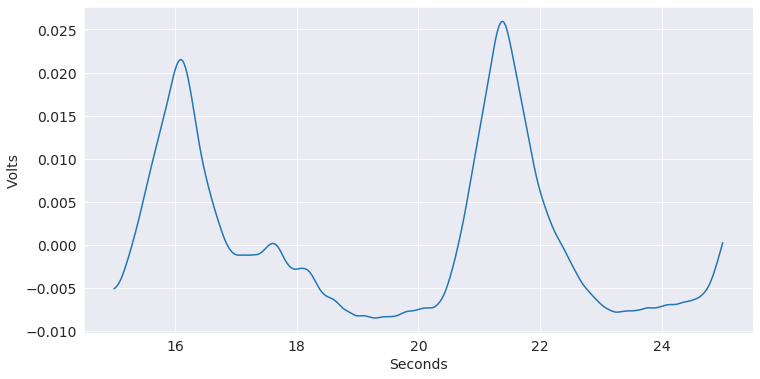

In [93]:
plt.plot(time[150000:250000],rsp_clean_kho[150000:250000])
plt.xlabel("Seconds")
plt.ylabel("Volts")

## RSP clean - BioSPPy's method
second order [0.1 - 0.35 Hz] 

bandpass Butterworth filter

constant detrending


[docs](https://github.com/neuropsychology/NeuroKit/blob/master/neurokit2/rsp/rsp_clean.py)

In [100]:
rsp_clean_biosppy = nk2.rsp_clean(bio_df['RSP'], sampling_rate=fs, method='biosppy')

Text(0, 0.5, 'Volts')

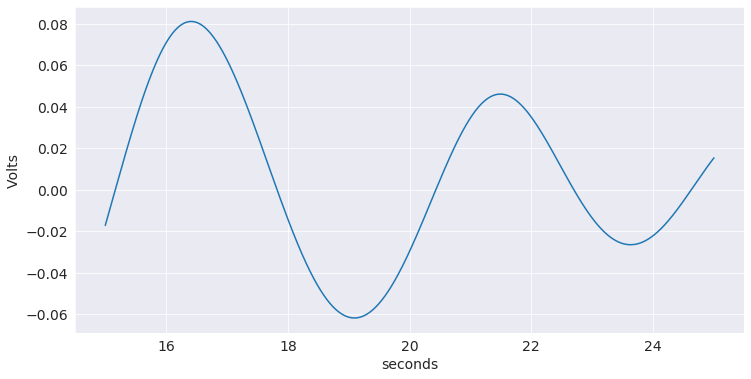

In [101]:
plt.plot(time[150000:250000], rsp_clean_biosppy[150000:250000])
plt.xlabel("seconds")
plt.ylabel("Volts")

In [102]:
rsp_proc, rsp_info = nk2.rsp_process(bio_df['RSP'], sampling_rate=fs, method='khodadad2018')

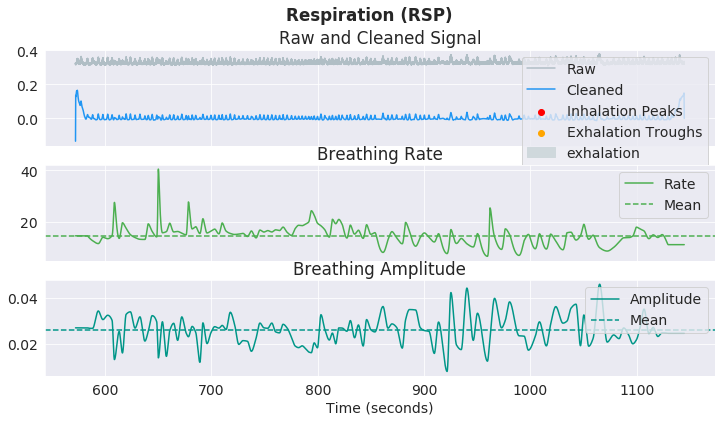

In [103]:
rsp_fig = nk2.rsp_plot(rsp_proc, sampling_rate=fs)

# PPG
unusable signal... should define minimal amplitude bracket to consider valid 

Text(0, 0.5, 'Volts')

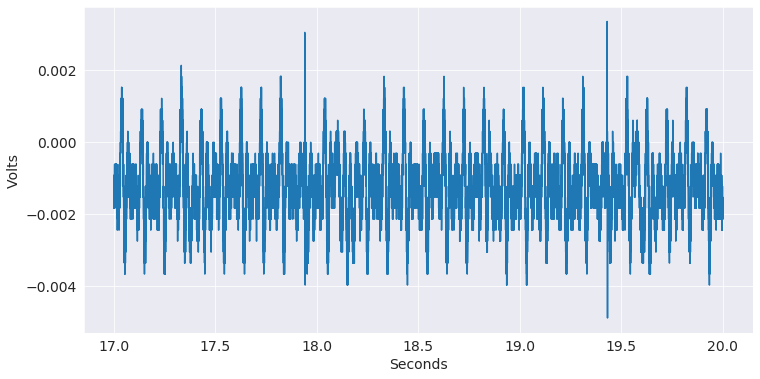

In [109]:
plt.plot(time[170000:200000], bio_df['PPG'][170000:200000])
plt.xlabel("Seconds")
plt.ylabel("Volts")

In [110]:
ppg_clean = nk2.ppg_clean(bio_df['PPG'], sampling_rate=fs)

Text(0, 0.5, 'Volts')

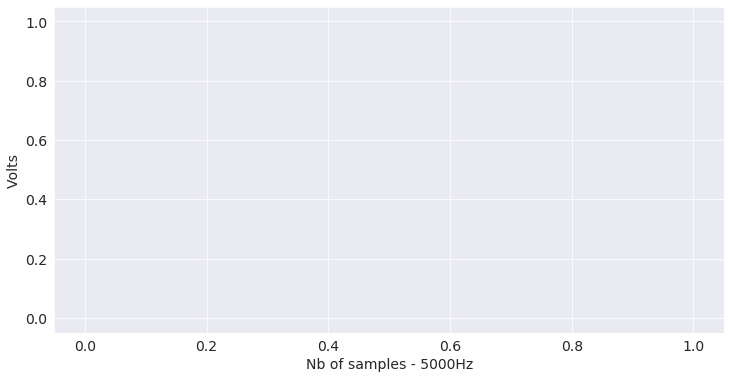

In [111]:
plt.plot(time[100000:200000], ppg_clean[100000:200000])
plt.xlabel("seconds")
plt.ylabel("Volts")

# ECG

Text(0, 0.5, 'Volts')

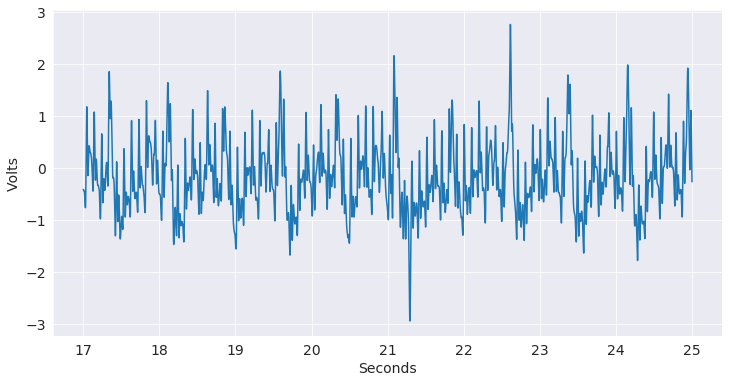

In [113]:
plt.plot(time[200000:500000], bio_df['ECG'][200000:500000])
plt.xlabel("Seconds")
plt.ylabel("Volts")

In [114]:
ecg = bio_df['ECG']

In [132]:
signals = pd.DataFrame({"ECG_Raw" : ecg,
"ECG_NeuroKit" : nk2.ecg_clean(ecg, sampling_rate=fs, method="neurokit"),
"ECG_BioSPPy" : nk2.ecg_clean(ecg, sampling_rate=fs, method="biosppy"),
"ECG_PanTompkins" : nk2.ecg_clean(ecg, sampling_rate=fs, method="pantompkins1985"),
"ECG_Hamilton" : nk2.ecg_clean(ecg, sampling_rate=fs, method="hamilton2002"),
"ECG_Elgendi" : nk2.ecg_clean(ecg, sampling_rate=fs, method="elgendi2010"),
"ECG_EngZeeMod" : nk2.ecg_clean(ecg, sampling_rate=fs, method="engzeemod2012")})

In [294]:
signals['time'] = time

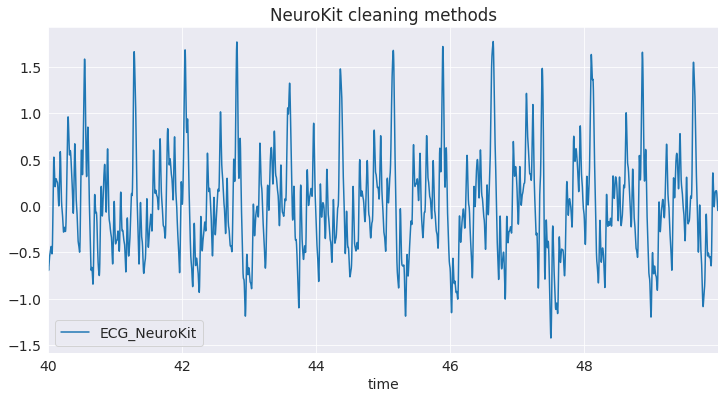

In [306]:
signals[['ECG_NeuroKit', 'time']][400000:500000].plot(title='NeuroKit cleaning methods', x='time')

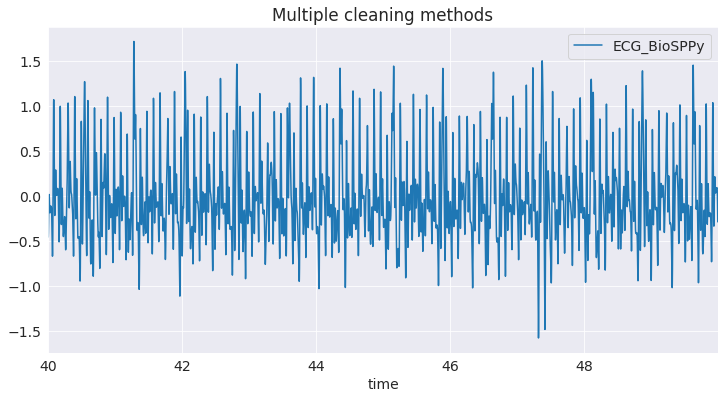

In [308]:
signals[['ECG_BioSPPy', 'time']][400000:500000].plot(title='BioSPPy cleaning methods', x="time")

In [232]:
cleaned=signals['ECG_NeuroKit'][400000:600000]

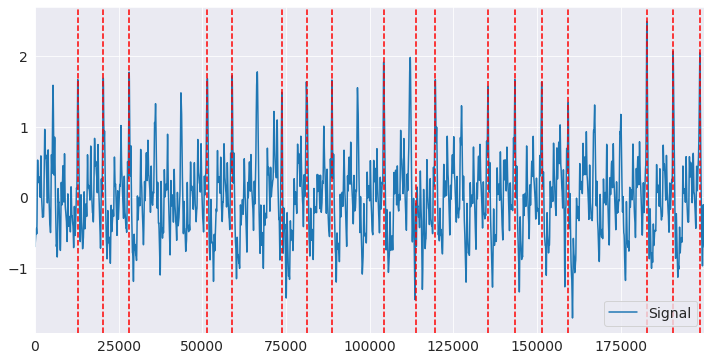

In [313]:
info = nk2.ecg_findpeaks(np.array(cleaned),sampling_rate=fs)
figs = nk2.events_plot(info["ECG_R_Peaks"], np.array(cleaned))

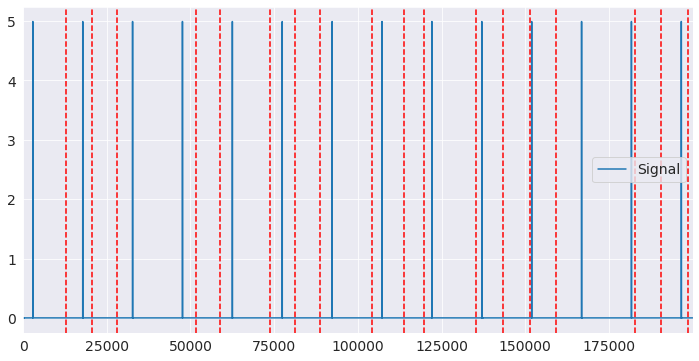

In [312]:
ecg_signals, info = nk2.ecg_peaks(np.array(cleaned), sampling_rate=fs, correct_artifacts=True)
figs = nk2.events_plot(info["ECG_R_Peaks"], np.array(bio_df['TTL'][400000:600000]))

In [203]:
pylab.rcParams['figure.figsize'] = (15.0, 9.0) 

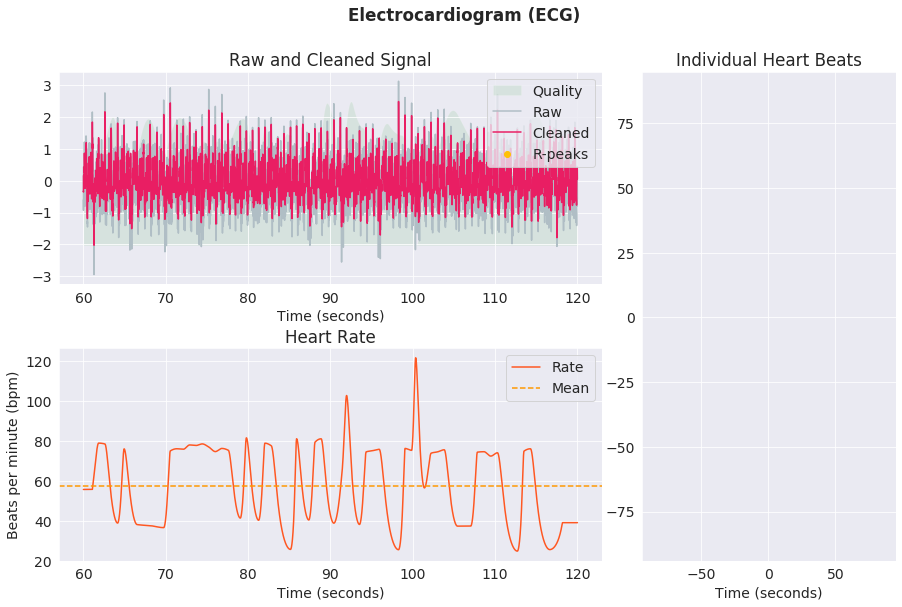

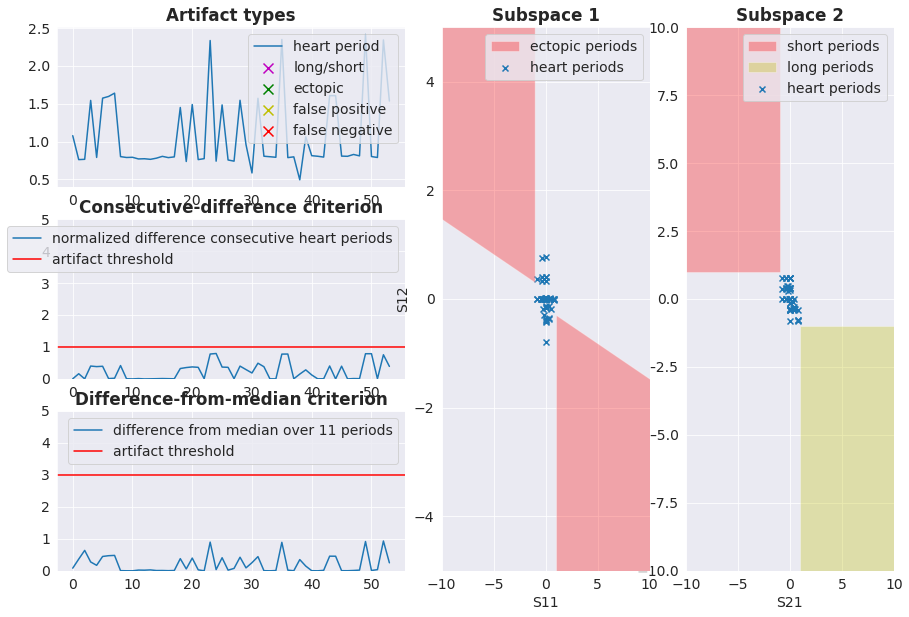

In [169]:
ecg_sig, info = nk2.ecg_process(ecg[200000:600000], sampling_rate=fs)
figs = nk2.ecg_plot(ecg_sig, sampling_rate=fs, show_type='full')

## Manually edit peak detection with Peakdet
![](https://peakdet.readthedocs.io/en/latest/_images/physio_edit.gif)